DSC 630  
Week 7 Hotel Recommendations  
Lara Clasen

In [3]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import svm

In [5]:
data_type={'is_booking':bool,'srch_ci' : np.str_, 'srch_co' : np.str_,
           'srch_adults_cnt' : np.int32, 'srch_children_cnt' : np.int32,
           'srch_rm_cnt' : np.int32, 'srch_destination_id':np.int32,
           'user_location_country' : np.int32, 'user_location_region' : np.int32,
           'user_location_city' : np.int32, 'hotel_cluster' : np.int32,
           'orig_destination_distance':np.float64, 'date_time':np.str_,
           'hotel_market':np.int32}
d_type={'is_booking':bool, 'cnt':np.int32, 'hotel_cluster' : np.int32,'srch_destination_id':np.int32}

We'll randomly sample 1% of our records so that we can work with a smaller number of records. 1% of our total records is 241,179 rows. Reading specifically 1% of the data is still a huge process, so rather I will specify the number of rows to be read in.

In [4]:
df = pd.read_csv('train.csv', nrows=241179)

In [7]:
dest = pd.read_csv('destinations.csv', nrows=241179)

In [8]:
df.shape

(241179, 24)

In [9]:
df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


The goal is to predict which hotel cluster a user will book based on their search information.

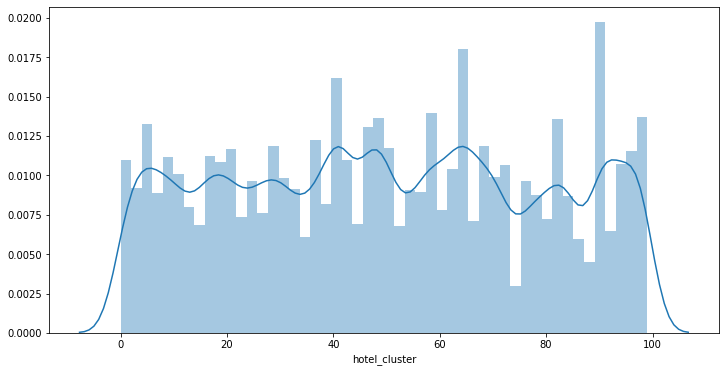

In [10]:
plt.figure(figsize=(12, 6))
sns.distplot(df['hotel_cluster'])

The data is pretty well distributed over all 100 clusters and there is skewness in the data.

In [11]:
from datetime import datetime
def get_year(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').year
        except ValueError:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year
    else:
        return 2013
    pass

def get_month(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').month
        except:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month
    else:
        return 1
    pass
    
def left_merge_dataset(left_dframe, right_dframe, merge_column):
    return pd.merge(left_dframe, right_dframe, on=merge_column, how='left')

In [12]:
# dealing with date_time column

df['date_time_year'] = pd.Series(df.date_time, index = df.index)
df['date_time_month'] = pd.Series(df.date_time, index = df.index)

from datetime import datetime
df.date_time_year = df.date_time_year.apply(lambda x: get_year(x))
df.date_time_month = df.date_time_month.apply(lambda x: get_month(x))

del df['date_time']

In [13]:
# work on srch_ci column

df['srch_ci_year'] = pd.Series(df.srch_ci, index=df.index)
df['srch_ci_month'] = pd.Series(df.srch_ci, index=df.index)

# convert year & months to int
df.srch_ci_year = df.srch_ci_year.apply(lambda x: get_year(x))
df.srch_ci_month = df.srch_ci_month.apply(lambda x: get_month(x))

# remove the srch_ci column
del df['srch_ci']

In [14]:
# work on srch_co column

df['srch_co_year'] = pd.Series(df.srch_co, index=df.index)
df['srch_co_month'] = pd.Series(df.srch_co, index=df.index)

# convert year & months to int
df.srch_co_year = df.srch_co_year.apply(lambda x: get_year(x))
df.srch_co_month = df.srch_co_month.apply(lambda x: get_month(x))

# remove the srch_co column
del df['srch_co']

In [15]:
df.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,hotel_continent,hotel_country,hotel_market,hotel_cluster,date_time_year,date_time_month,srch_ci_year,srch_ci_month,srch_co_year,srch_co_month
0,2,3,66,348,48862,2234.2641,12,0,1,9,...,2,50,628,1,2014,8,2014,8,2014,8
1,2,3,66,348,48862,2234.2641,12,0,1,9,...,2,50,628,1,2014,8,2014,8,2014,9
2,2,3,66,348,48862,2234.2641,12,0,0,9,...,2,50,628,1,2014,8,2014,8,2014,9
3,2,3,66,442,35390,913.1932,93,0,0,3,...,2,50,1457,80,2014,8,2014,11,2014,11
4,2,3,66,442,35390,913.6259,93,0,0,3,...,2,50,1457,21,2014,8,2014,11,2014,11


Now we want to know if anything correlates well with hotel_cluster. This will tell us if we should pay more attention to any particular columns.

In [16]:
df.corr()["hotel_cluster"].sort_values()

srch_destination_type_id    -0.032703
is_booking                  -0.025072
hotel_country               -0.024589
user_location_country       -0.019496
site_name                   -0.017220
srch_destination_id         -0.012454
hotel_continent             -0.010452
srch_rm_cnt                 -0.006863
srch_co_month               -0.001469
user_id                     -0.001451
srch_ci_month               -0.000674
date_time_year              -0.000291
channel                      0.001750
user_location_city           0.001841
is_mobile                    0.002152
date_time_month              0.005345
cnt                          0.005454
srch_adults_cnt              0.008681
posa_continent               0.009592
user_location_region         0.010308
srch_ci_year                 0.010501
srch_co_year                 0.011062
srch_children_cnt            0.013202
orig_destination_distance    0.013668
hotel_market                 0.033555
is_package                   0.049519
hotel_cluste

None of the columns correlate linearly with hotel_cluster, which means that linear regression and logistic regression won't work well on our data.

In [17]:
df.shape

(241179, 27)

Known combinations of user location cities, origin-destination distances and search destinations will be helpful in finding hotel clusters.

In [18]:
pieces = [df.groupby(['srch_destination_id','hotel_country','hotel_market','hotel_cluster'])['is_booking'].agg(['sum','count'])]
agg = pd.concat(pieces).groupby(level=[0,1,2,3]).sum()
agg.dropna(inplace=True)

In [19]:
agg.head()

sum  count
srch_destination_id hotel_country hotel_market hotel_cluster            
8                   50            416          32               1      2
                                               48               1      3
                                               60               1      4
                                               77               1      2
9                   150           2101         75               0      1

In [20]:
agg['sum_and_cnt'] = 0.85*agg['sum'] + 0.15*agg['count']
agg = agg.groupby(level=[0,1,2]).apply(lambda x: x.astype(float)/x.sum())
agg.reset_index(inplace=True)

In [21]:
agg.head()

,srch_destination_id,hotel_country,hotel_market,hotel_cluster,sum,count,sum_and_cnt
0,8,50,416,32,0.25,0.181818,0.227723
1,8,50,416,48,0.25,0.272727,0.257426
2,8,50,416,60,0.25,0.363636,0.287129
3,8,50,416,77,0.25,0.181818,0.227723
4,9,150,2101,75,NaN,1.000000,1.000000


In [22]:
agg_pivot = agg.pivot_table(index=['srch_destination_id','hotel_country','hotel_market'], columns='hotel_cluster', values='sum_and_cnt').reset_index()

In [23]:
agg_pivot.head()

hotel_cluster,srch_destination_id,hotel_country,hotel_market,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,8,50,416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,150,2101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11,50,824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.884615,NaN,NaN,NaN,NaN,NaN
3,14,27,1434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16,50,419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df = pd.merge(df, dest, how='left', on='srch_destination_id')
df = pd.merge(df, agg_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])

In [25]:
df.fillna(0, inplace=True)

In [26]:
df.shape

(241179, 276)

We only want to focus on booking events.

In [27]:
df = df.loc[df['is_booking'] == 1]

In [28]:
X = df.drop(['user_id', 'hotel_cluster', 'is_booking'], axis=1)
y = df.hotel_cluster

In [29]:
X.shape, y.shape

((20258, 273), (20258,))

In [30]:
y.nunique()

100

K-Nearest Neighbors:

In [33]:
from sklearn.neighbors import KNeighborsClassifier

clf = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=5))
np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy'))

0.26661928634093374